In [12]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
Xtest = pd.read_csv(Path('data/Xtest.csv'))
Xtrain = pd.read_csv(Path('data/Xtrain.csv'))
Ytrain = pd.read_csv(Path('data/Ytrain.csv'))
Ysample = pd.read_csv(Path('data/Ysample.csv'))

Rows and Columns of the data sets

In [3]:
print('X Training Set :', Xtrain.shape)
print('Y Training Set :',Ytrain.shape)
print('X Testing Set  :',Xtest.shape)
print('Y Sample Set   :',Ysample.shape)

X Training Set : (31119, 12)
Y Training Set : (31119, 2)
X Testing Set  : (13752, 12)
Y Sample Set   : (13752, 2)


Dataset structure

    k is used to specify the train, s for the station and d for the day. One stop is given by the triplet k, s, d

Contextual variables

    date d: YYYYMMDD is the date of the train id run
    train k: 1, 2, …, 55 train id (unique by day d)
    station s: AA, AB, AC,… is the station id
    hour: HH:00:00 is the time slot
    way: 0, 1 is the train way with 0 (toward Paris) or 1 (toward suburb)
    composition: 1, 2 is the number of train units (one or two)

Lags variables

    p1q0 ∈ [0,1] is the occupancy rate of the previous train k-1 at the same station s
    p2q0 ∈ [0,1] is the occupancy rate of the second previous train k-2 at the same station s
    p3q0 ∈ [0,1] is the occupancy rate of the third previous train k-3 at the same station s
    p0q1 ∈ [0,1] is the occupancy rate of the same train k at the previous station s-1
    p0q2 ∈ [0,1] is the occupancy rate of the same train k at the second previous station s-2
    p0q3 ∈ [0,1] is the occupancy rate of the same train k at the third previous station s-3

The lag variables are NA if the lag does not exist for the stop because of timetable structure


In [4]:
print(Xtrain.info())
print(Xtrain.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.8+ MB
None
         date  train  way station      hour  composition  p1q0  p2q0  p3q0  \
0  2019-01-07      1    0      AD  06:00:00            2   NaN   NaN   NaN   
1  2019-01-08      1    0      AD  06:00:00            2   NaN   NaN   NaN   
2 

Missing Values

In [5]:
Xtrain.isna().sum()

date              0
train             0
way               0
station           0
hour           3204
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
dtype: int64

Unique Values

Trains ONLY going to paris
Trains have either 2 or 1 carts

In [6]:
print(Xtrain['way'].unique())
print(Xtrain['composition'].unique())

[0]
[2 1]


Add Weekday and Month to dataset

In [7]:
Xtrain_date = Xtrain.copy()

# convert Time to Datetime
Xtrain_date['date'] = pd.to_datetime(Xtrain_date['date'], format='%Y/%m/%d')

# Add new column for weekday
weekday = Xtrain_date['date'].dt.day_name()
month = Xtrain_date['date'].dt.month_name()
Xtrain_date.insert(1,'weekday',weekday)
Xtrain_date.insert(2,'month',month)
Xtrain_date

,date,weekday,month,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,2019-01-07,Monday,January,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
1,2019-01-08,Tuesday,January,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2,2019-01-10,Thursday,January,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
3,2019-01-11,Friday,January,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
4,2019-01-14,Monday,January,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,Monday,May,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
31115,2019-05-14,Tuesday,May,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
31116,2019-05-15,Wednesday,May,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN
31117,2019-03-21,Thursday,March,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN


In [8]:
Xtrain.groupby(['composition']).size()

composition
1       11
2    31108
dtype: int64

Number of weekday entry points

Unique Weekdays: ['Monday' 'Tuesday' 'Thursday' 'Friday' 'Wednesday']


<AxesSubplot: xlabel='count', ylabel='weekday'>

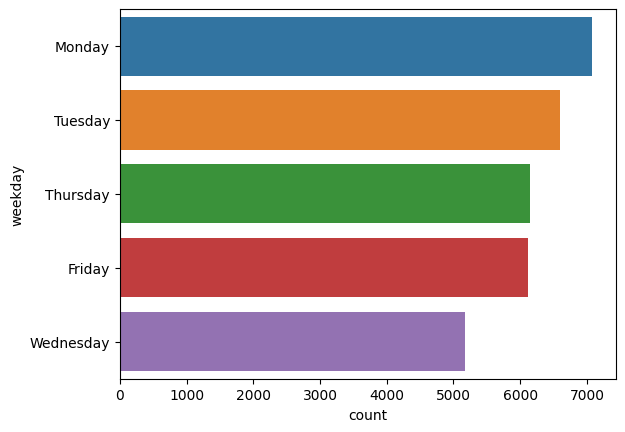

In [9]:
print(f'Unique Weekdays: {Xtrain_date["weekday"].unique()}')
sns.countplot(y=Xtrain_date['weekday'])

Number of Month entry points

Unique Montsh: ['January' 'February' 'March' 'April' 'May']


<AxesSubplot: xlabel='count', ylabel='month'>

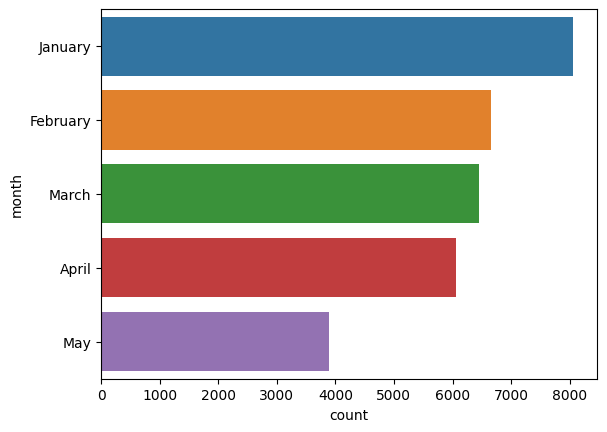

In [10]:
print(f'Unique Montsh: {Xtrain_date["month"].unique()}')
sns.countplot(y=Xtrain_date['month'])

Number of hour entry points - most active hours?

Unique Times: ['06:00:00' '07:00:00' nan '08:00:00' '09:00:00' '11:00:00']


<AxesSubplot: xlabel='count', ylabel='hour'>

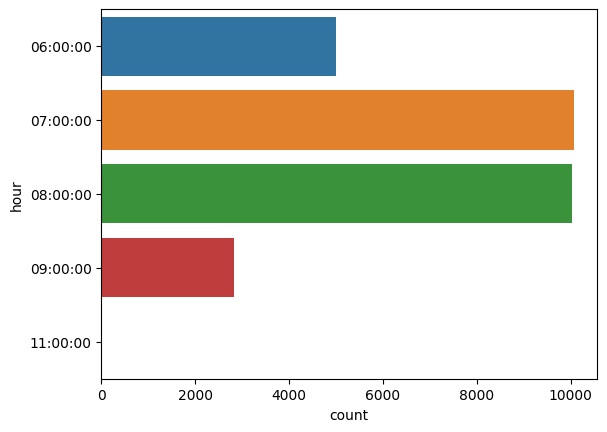

In [11]:
print(f'Unique Times: {Xtrain_date["hour"].unique()}')
sns.countplot(y=Xtrain_date['hour'])

### Correlation Matrix

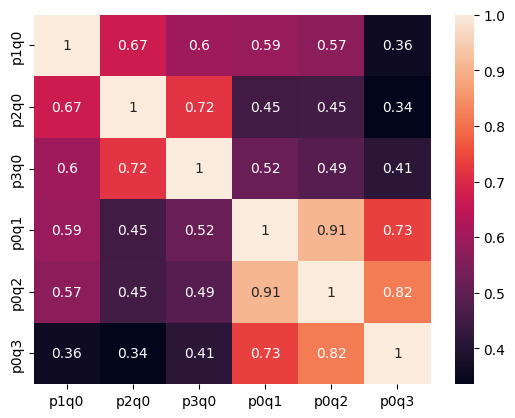

In [16]:
corr_matrix = Xtrain_date[['p1q0','p2q0','p3q0','p0q1','p0q2','p0q3']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()